In [2]:
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from pylab import rcParams
import os
import gzip
from tqdm import tqdm
import pandas as pd
import numpy as np

%matplotlib inline
%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 20, 10

In [3]:
full_df = pd.read_csv('full_df.csv')

full_df = full_df[full_df['IndoorProb']!=100]

In [5]:
full_df.head()

,Unnamed: 0,Patient,Cohort,Day,StepPerSec,Timestamp,IndoorProb
29017,29017,1000,HA,Day1,0.875,1597302217,0
29018,29018,1000,HA,Day1,0.875,1597302218,0
29019,29019,1000,HA,Day1,0.875,1597302219,0
29020,29020,1000,HA,Day1,0.875,1597302220,0
29021,29021,1000,HA,Day1,0.875,1597302221,0


In [8]:
full_df.reset_index(inplace=True)

In [9]:
full_df['Patient'].unique()

array([1000, 1001, 1002, 1003, 1004, 1005, 1006, 1007, 1008, 1009, 1010,
       1011, 1012, 1013, 1014, 1015, 1016, 1017, 1018, 1019, 1020, 1021,
       1022, 1023, 1024, 1025, 1026, 1027, 1028, 1029, 2000, 2001, 2002,
       2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013,
       3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009, 3010,
       3011, 3013, 3014, 4002, 4005, 4011, 4013, 4019, 5000, 5003, 5005,
       5008, 5009, 5010, 5012, 5019], dtype=int64)

In [72]:
len(full_df['Patient'].unique())

71

<AxesSubplot:>

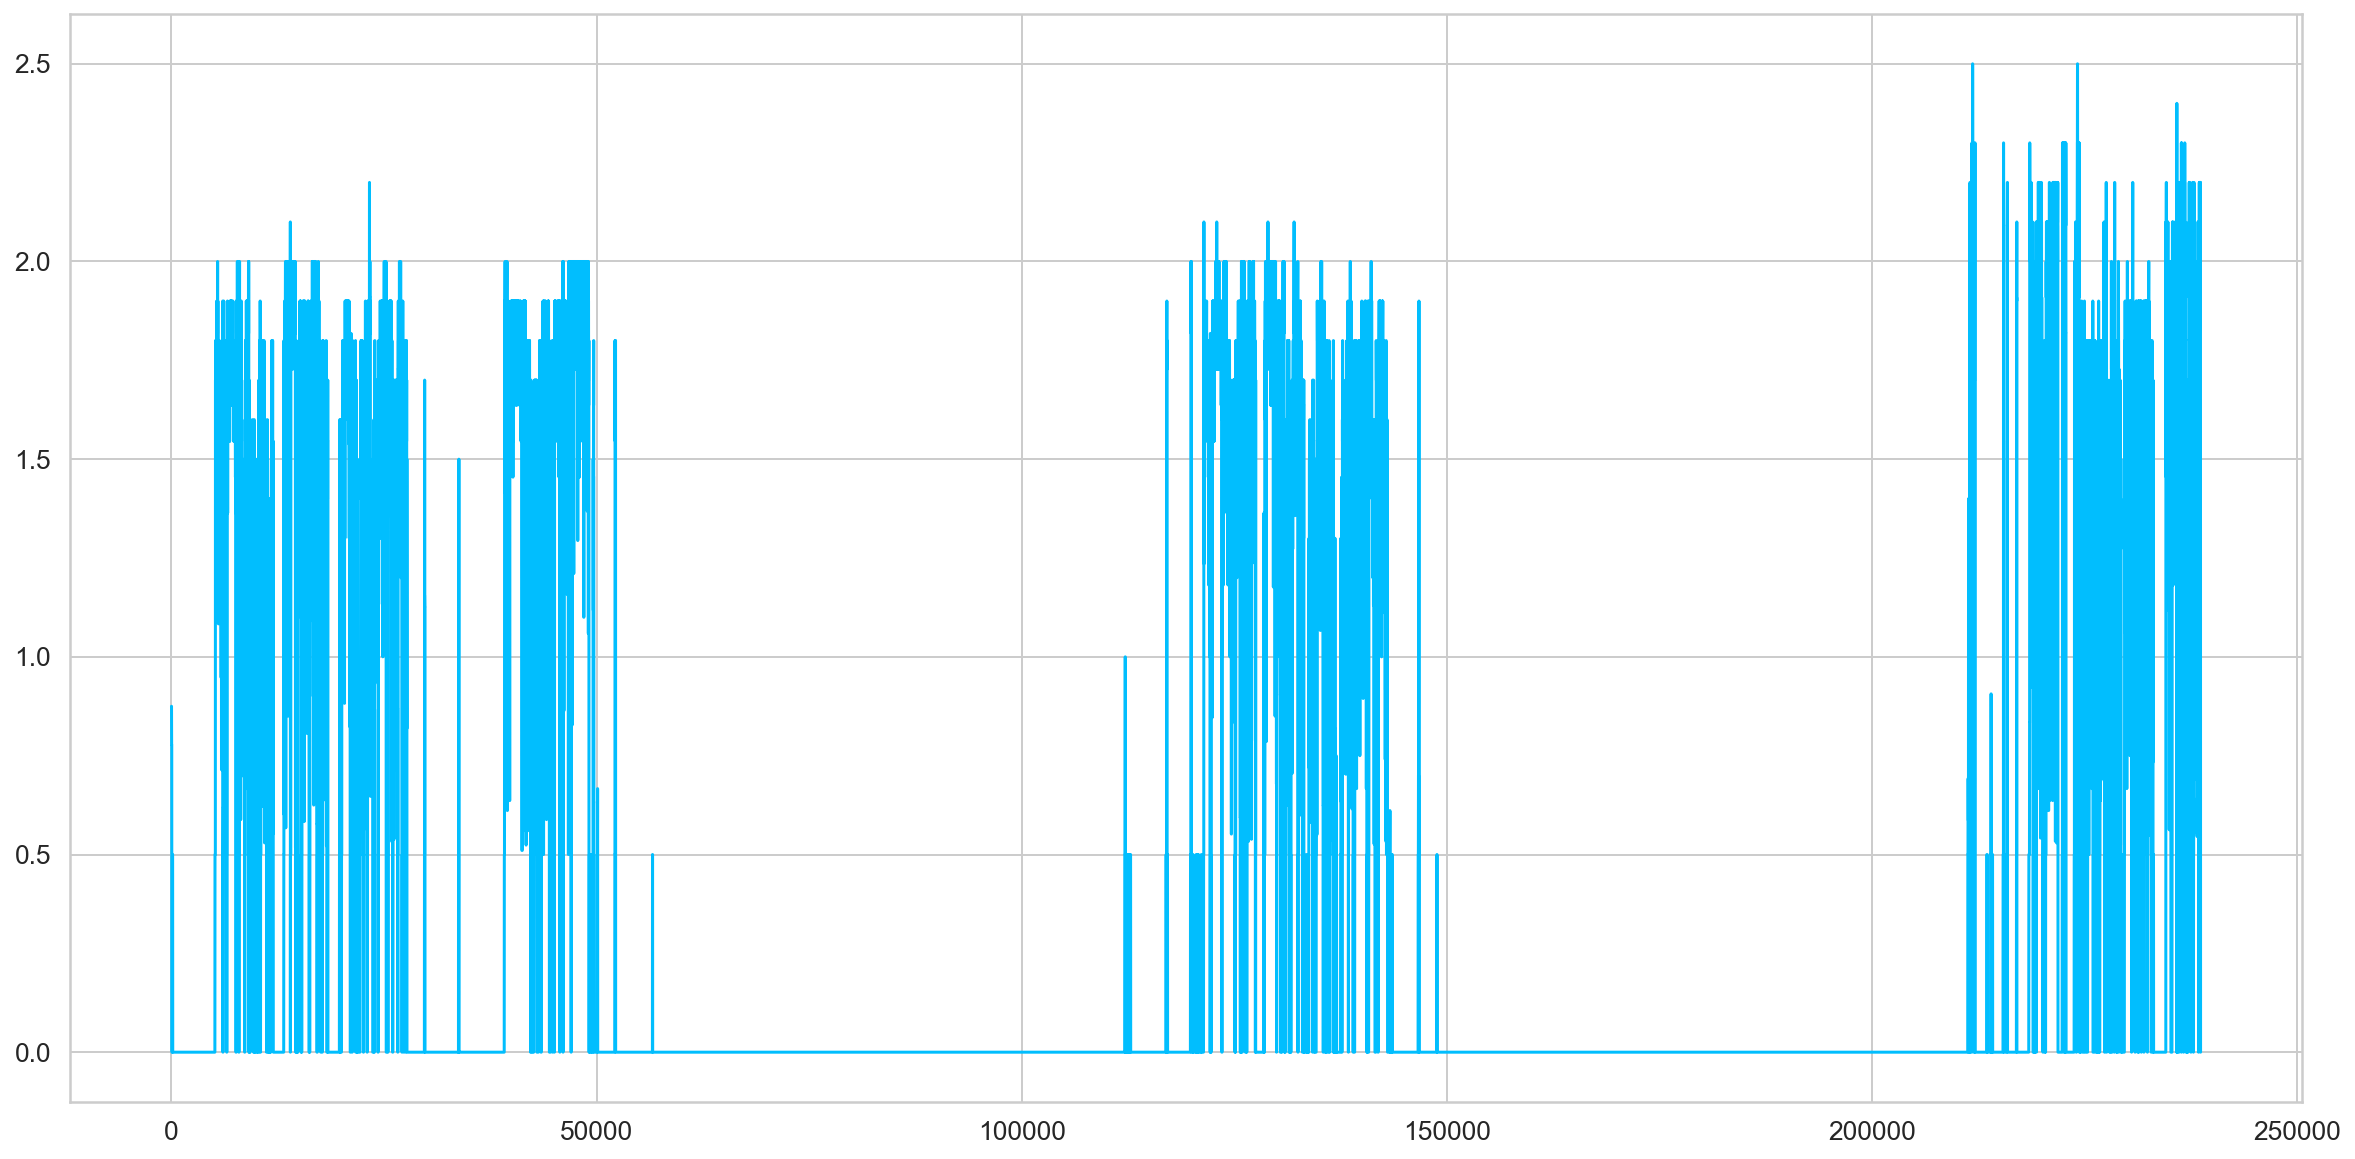

In [10]:
full_df[full_df['Patient']==1000].StepPerSec.plot()

In [ ]:
#walking.StepPerSec.plot()

In [93]:
def extracting_daily_weather(folder, sort=False):
    daily_stats = []
    non_valid_stats = []
    num_days = list(range(1,8))
    for f in os.listdir(folder):
        if f.startswith('weather') and f.endswith('.json'):
            w_file = pd.read_json(os.path.join(folder, f))
            day = f.split('-')[3]
            num_days.remove(int(day[-1]))
            daily_stats.append((day,
                w_file['data'][0]['temp'],
                w_file['data'][0]['wind_speed']))
            #format: day, temp, wind speed, wind dir, precip, snow
    if num_days:
        for d in num_days:
            non_valid_stats.append((f'Day{d}', 'NaN', 'NaN'))
    if sort:
        return sorted(daily_stats, key=lambda x: x[1], reverse=True)
    return daily_stats+non_valid_stats

In [94]:
def daily_stats(df, feat, day=None):
    if day is None:
        return np.array([
            [np.mean(df[feat])],
            [np.median(df[feat])],
            [np.std(df[feat])],
            [np.max(df[feat])],
            [np.min(df[feat])]
        ])
    else:
        d_df = df[df['Day']==day]
        return np.array([
            [np.mean(d_df[feat])],
            [np.median(d_df[feat])],
            [np.std(d_df[feat])],
            [np.max(d_df[feat])],
            [np.min(d_df[feat])]
        ])

In [109]:
def create_full_df(folder, df, id):
    step_level = ['StepPerSec', 'StepPerMin']
    stats = ['mean', 'median', 'std', 'max', 'min']

    stats_overall = pd.concat([pd.DataFrame(np.swapaxes(daily_stats(df, s), 0,1), columns=[f'{s}_{i}' for i in stats]) for s in step_level], axis=1)
    stats_daily = pd.concat([pd.DataFrame(np.swapaxes(daily_stats(df, s, f'Day{j}'), 0,1), columns=[f'Day{j}_{s}_{i}' for i in stats]) for j in range(1,8) for s in step_level], axis=1)

    ds = extracting_daily_weather(folder)
    from_hot_to_cold = extracting_daily_weather(folder, sort=True)

    weather_stats = pd.DataFrame(np.swapaxes(np.array([
        [from_hot_to_cold[0][0]], [from_hot_to_cold[0][1]], [from_hot_to_cold[-1][0]], [from_hot_to_cold[-1][1]]] + [[ds[i][2]] for i in range(7)]), 0,1), 
        columns=['hottest_day', 'hottest_temp', 'coldest_day', 'coldest_temp']+[f'Day{i}_wind_speed' for i in range(1,8)])

    final_weath_df = pd.concat([pd.DataFrame([sum(df['StepPerSec'].values)], columns=['NumOfSteps']), pd.DataFrame([id], columns=['ID']), stats_overall, weather_stats, stats_daily], axis=1)

    return final_weath_df

In [ ]:
final_df = pd.DataFrame()
for el in full_df['Patient'].unique():
    p_df = full_df[full_df['Patient']==el]
    #p_df['series_id'] = np.arange(len(p_df)) // 10 + 1

    #valid_idx = []
    #for _,group in tqdm(p_df[p_df['StepPerSec'] > 0.75].groupby(['series_id', 'Patient']), position=0, leave=True):
    #    valid_idx+=group.index.values.tolist()

    #valid_idx
    #walking = p_df.loc[valid_idx]
    walking = p_df[p_df['StepPerSec'] > 0]
    walking.reset_index(inplace=True)
    walking['StepPerMin'] = [el*60 for el in walking['StepPerSec'].values]
    
    folder = f'mobilised-contextual-factors-v1/{el}'
    
    s_df = create_full_df(folder, walking, el)
    final_df = pd.concat([final_df, s_df])

In [122]:
final_df.to_csv('weather_id_00thresh.csv')

In [ ]:
final_df = pd.DataFrame()
for el in full_df['Patient'].unique():
    p_df = full_df[full_df['Patient']==el]
    p_df['series_id'] = np.arange(len(p_df)) // 10 + 1

    #valid_idx = []
    #for _,group in tqdm(p_df[p_df['StepPerSec'] > 0.75].groupby(['series_id', 'Patient']), position=0, leave=True):
    #    valid_idx+=group.index.values.tolist()

    #valid_idx
    #walking = p_df.loc[valid_idx]
    walking = p_df[p_df['StepPerSec'] > 0.5]
    walking.reset_index(inplace=True)
    walking['StepPerMin'] = [el*60 for el in walking['StepPerSec'].values]
    
    folder = f'mobilised-contextual-factors-v1/{el}'
    
    s_df = create_full_df(folder, walking, el)
    final_df = pd.concat([final_df, s_df])

In [124]:
final_df.to_csv('weather_id_05thresh.csv')